## Load and Eval Functions

conda install pytorch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 cudatoolkit=11.3 -c pytorch

In [1]:
from nilearn import surface
from nilearn import datasets as ndatasets
import numpy as np
from sklearn.model_selection import train_test_split
from ridge import bootstrap_ridge
import seaborn as sns

def get_data(sub,task):
    """From a subject and a task creates a dictionary containing the subject's neural activity in both hemispheres that was collected during the task

    Args:
        sub (str): subject code. For example: '001'
        task (str): task name. For example: 'tunnel'

    Returns:
        Dict
    """
    # LOAD THE NEURAL DATA USING NILEARN
    neural_data_L=surface.load_surf_data("/home/meiri.yoav/w2b_data/afni-nonsmooth/sub-"+sub+"/func/sub-"+sub+"_task-"+task+"_space-fsaverage6_hemi-L_desc-clean.func.gii")
    neural_data_R=surface.load_surf_data("/home/meiri.yoav/w2b_data/afni-nonsmooth/sub-"+sub+"/func/sub-"+sub+"_task-"+task+"_space-fsaverage6_hemi-R_desc-clean.func.gii")
    
    surf_tpl=ndatasets.fetch_surf_fsaverage(mesh="fsaverage6")
    
    output={"neural_data_L":neural_data_L,"neural_data_R":neural_data_R,"fsaverage6_tpl":surf_tpl}
    return output

def create_transcript(task: str, sub: str):
    """Returns a dict which contains the task, the subject id, and a pandas dataframe where each records holds a word from the story, it's version after tokenization, it's onset and offset 
    in terms of TR's that passed from the moment the experiment began.

    Args:
        task (str): nerative name
        sub (str): subject id

    Returns:
        dict
    """
    import pandas as pd
    import numpy as np

    transcript=pd.read_csv(f"/home/meiri.yoav/w2b_data/{task}/align.csv",names=["word_orig","word","onset","offset"])
    transcript=transcript.dropna().reset_index(drop=True)
    onset = pd.read_table("/home/meiri.yoav/w2b_data/first_TRs/sub-"+sub+"_task-"+task+"_events.tsv").onset[0]
    TR=1.5
    transcript["TR_onset"]=(onset+transcript.onset)//TR
    transcript["TR_offset"]=(onset+transcript.offset)//TR
    transcript = transcript.astype({'TR_onset': 'int32', 'TR_offset': 'int32'})
    return {'transcript': transcript, 'task': task, 'sub': sub}


def get_neural_data(sub, task, TRs):
    import numpy as np
    import pandas as pd
    
    neural_data=get_data(sub,task)
    nd_concat = np.vstack((neural_data['neural_data_L'], neural_data['neural_data_R'])) # Voxal_num X No._Voxels
    # print(neural_data['neural_data_L'].shape, neural_data['neural_data_R'].shape, nd_concat.shape)
    return nd_concat.T[TRs]


def ridge_n_plot(X, y, print_plot=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    wt, corrs, valphas, allRcorrs, valinds = bootstrap_ridge(Rstim=X_train, Rresp=y_train, Pstim=X_test, Presp=y_test, alphas=np.logspace(0, 3, 20)
                                , nboots=5,chunklen=10,nchunks=int((0.2*844*0.8)/10),return_wt=True)

    if print_plot:
        g = sns.displot(corrs, stat="probability", common_norm=False, kde=True)
        g.set_axis_labels("Correlation", "Proportion of voxels in this interval")
    
    return wt, corrs

def plot_stat_map(corrs_total_brain, threshold=0.1, vmax=0.6, cmap='cold_hot'):
    from nilearn import plotting
    import matplotlib.pyplot as plt
    figure, axes = plt.subplots(2,2,subplot_kw={"projection": "3d"},figsize=[15,10])
    plt.subplots_adjust(wspace=-0.1, hspace=-0.1)

    
    SM=corrs_total_brain
    SM_l = SM[:40962]
    SM_r = SM[40962:]
    surf_tpl=ndatasets.fetch_surf_fsaverage(mesh="fsaverage6")
    mask_L=surface.load_surf_data("/home/meiri.yoav/w2b_data/afni-nonsmooth/tpl-fsaverage6/tpl-fsaverage6_hemi-L_desc-cortex_mask.gii")
    mask_R=surface.load_surf_data("/home/meiri.yoav/w2b_data/afni-nonsmooth/tpl-fsaverage6/tpl-fsaverage6_hemi-R_desc-cortex_mask.gii")

    plotting.plot_surf_stat_map(surf_tpl["pial_left"],SM_l*mask_L,hemi="left",view="lateral",colorbar=True,threshold=threshold,vmax=vmax,bg_map=surf_tpl["sulc_left"],axes=axes[0,0], cmap=cmap)
    plotting.plot_surf_stat_map(surf_tpl["pial_right"],SM_r*mask_R,hemi="right",view="lateral",colorbar=True,threshold=threshold,vmax=vmax,bg_map=surf_tpl["sulc_right"],axes=axes[0,1], cmap=cmap)
    plotting.plot_surf_stat_map(surf_tpl["pial_left"],SM_l*mask_L,hemi="left",view="medial",colorbar=True,threshold=threshold,vmax=vmax,bg_map=surf_tpl["sulc_left"],axes=axes[1,0], cmap=cmap)
    plotting.plot_surf_stat_map(surf_tpl["pial_right"],SM_r*mask_R,hemi="right",view="medial",colorbar=True,threshold=threshold,vmax=vmax,bg_map=surf_tpl["sulc_right"],axes=axes[1,1], cmap=cmap)
    plt.show()

## Get neural data and transcript

In [2]:
import numpy as np
import pandas as pd
import importlib

participants=pd.read_table("/home/meiri.yoav/w2b_data/participants.tsv")
task="tunnel"
participants_in_task=[participants.participant_id[i] for i in range(len(participants)) if task in participants.task[i]]
subs=[a.split("-")[1] for a in participants_in_task]

# In the paper they suggested to exclude these participants
subs.remove('004')
subs.remove('013')

sub=subs[2]
first_TR=pd.read_table("/home/meiri.yoav/w2b_data/first_TRs/sub-"+sub+"_task-"+task+"_events.tsv").onset[0]

In [3]:
print(subs)

['001', '005', '022', '025', '026', '041', '052', '053', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '069']


In [4]:
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
import torch

HF_model="gpt2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained(HF_model)

transcript = create_transcript(task=task, sub=sub)['transcript']
transcript['word'] = transcript['word'].apply(lambda x:  x if x != '<unk>' else tokenizer.unk_token)
TRs = pd.unique(transcript['TR_onset'])
transcript

,word_orig,word,onset,offset,TR_onset,TR_offset
0,Tonight,tonight,0.12,0.48,2,2
1,a,a,0.69,0.80,2,2
2,story,story,0.80,1.21,2,2
3,by,by,1.21,1.46,2,2
4,Pohl,<|endoftext|>,1.48,2.17,2,3
...,...,...,...,...,...,...
3304,out,out,1515.27,1515.36,1012,1012
3305,of,of,1515.36,1515.49,1012,1012
3306,a,a,1515.49,1515.54,1012,1012
3307,dream,dream,1515.54,1516.00,1012,1012


### Get neural data

In [5]:
all_neural_data = []
for sub in subs:
    y_sub = get_neural_data(sub, task, TRs)
    all_neural_data.append(y_sub)


In [6]:
all_neural_data = np.array(all_neural_data)
print(all_neural_data.shape)
y = np.nanmean(all_neural_data, axis=0)
non_zero_activity_indices = [i for i in range(y.shape[1]) if np.any(y[:, i])]
non_zero_activity_dict = {val: i for i, val in enumerate(non_zero_activity_indices)}
y = y[:, non_zero_activity_indices] #*  leave only voxels with meassured activity

zs = lambda v: (v-v.mean(0))/v.std(0)
y = np.array([zs(tr) for tr in y])
print(y.shape)

(21, 844, 81924)
(844, 74947)


In [7]:
words = transcript['word'].to_list() # A list of all words in the story Tunnel

## WS example - Average Brain

In [8]:
import torch
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)

cuda:1


In [9]:
def embedding_window_size(words,ws, HF_model="gpt2", device='cpu',printi=False, mean_last_hidden=False):
    from transformers import GPT2Tokenizer, GPT2Model
    import numpy as np
    from tqdm import tqdm
    
    from transformers import AutoTokenizer, AutoModelForMaskedLM
    
    tokenizer = GPT2Tokenizer.from_pretrained(HF_model)
    model = GPT2Model.from_pretrained(HF_model).to(device)

    
    vectors=[]
    for i in tqdm(range(len(words))):
        j= i-ws if i>ws else 0
        text=" ".join(words[j:i+1])
        inputs = tokenizer(text, return_tensors="pt").to(device)
        outputs = model(inputs.input_ids)
        if mean_last_hidden:
            last_word_embedding = np.mean(outputs[0].to("cpu").detach().numpy()[0], axis=0)
        else:
            last_word_embedding = outputs[0].to("cpu").detach().numpy()[0,-1,:]
        vectors.append(last_word_embedding)

    return np.array(vectors)

In [33]:
embds = embedding_window_size(words, ws=16, mean_last_hidden=True, device=device)
embds_lst = [v for v in embds]
transcript['embds'] = embds_lst
TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() # For each TR average the embeddings of all words that fall under this TR

X_ws = np.squeeze(np.array(TR_embds.values.tolist()))

100%|██████████| 3309/3309 [00:37<00:00, 88.24it/s]


In [34]:
print(X_ws.shape)

(844, 768)


In [35]:
wt, corrs_ws = ridge_n_plot(X_ws, y, print_plot=False)
print(f'{round(len([x for x in corrs_ws if x > 0.3]) / len(corrs_ws) * 100, 2)} % are bigger than 0.3')
pd.Series(corrs_ws).describe()

5.06 % are bigger than 0.3


count    74947.000000
mean         0.083745
std          0.127346
min         -0.422605
25%         -0.003148
50%          0.077852
75%          0.165850
max          0.592889
dtype: float64

In [36]:
print(corrs_ws.shape)

(74947,)


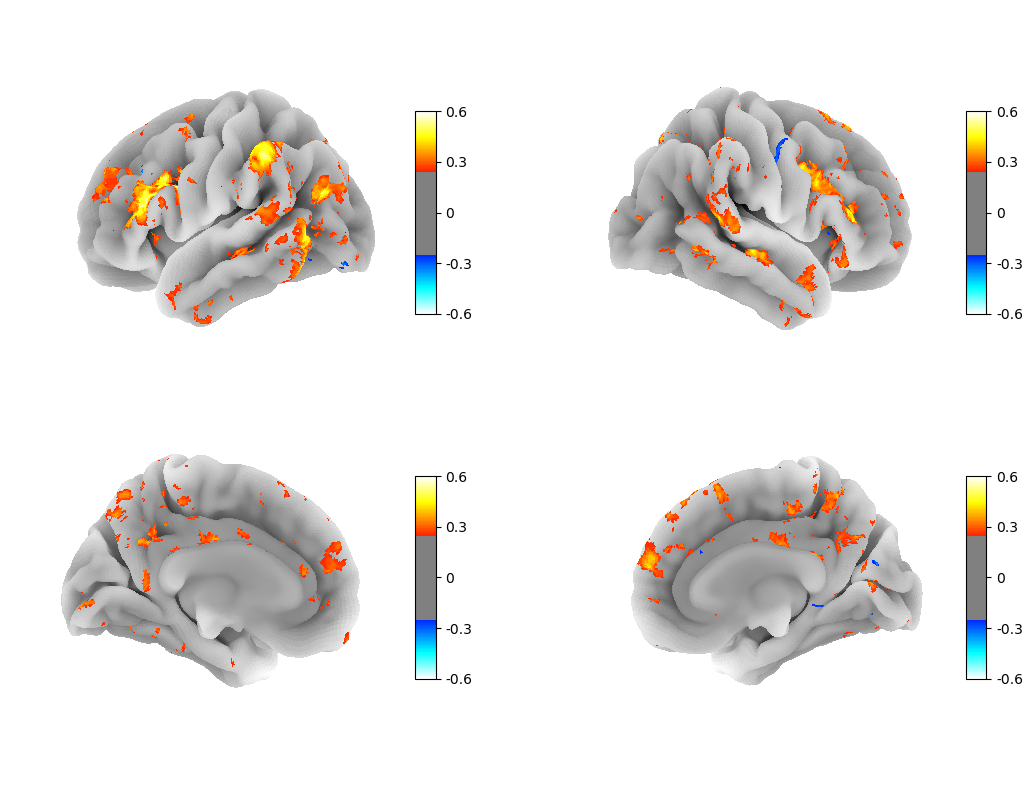

In [37]:
corrs_total_brain = np.zeros(40962*2)
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_ws[non_zero_activity_dict[non_zero_idx]]
    # corrs_total_brain[non_zero_idx] = 0
plot_stat_map(corrs_total_brain, threshold=0.25)


## PCA and Dimension Reduction

Principal component regression (PCR) is a regression analysis technique that is based on principal component analysis (PCA). It is used to overcome some of the limitations of linear regression by reducing the number of variables in the model and by removing multicollinearity between variables.

PCR can be more effective than linear regression when there are many correlated predictor variables because it can reduce multicollinearity and improve prediction accuracy. However, it can also be less interpretable than linear regression because it involves a transformation of the original variables into principal components.

In terms of R^2, PCR can sometimes perform better than linear regression because it can capture more of the variance in the data by using fewer variables. However, this is not always the case, and it depends on the specific dataset and problem at hand.

### Explained Variance

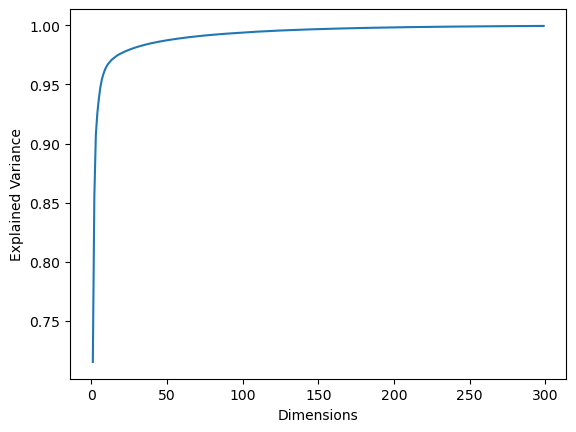

In [33]:
from sklearn.decomposition import PCA

def access_dim_reduction(X, max_dim, step):
    explained_var_vec = []
    
    for i in range(1, max_dim, step):
        pca = PCA(n_components=i)
        pca.fit(X)
        explained_var_vec.append(pca.explained_variance_ratio_.sum())
    
    df = pd.DataFrame({'Dimensions': list(range(1, max_dim, step)), 'Explained Variance': explained_var_vec})
    sns.lineplot(data=df, x='Dimensions', y='Explained Variance')

access_dim_reduction(X_ws, 300, 1)

### Comparing Different Dimension Sizes

In [34]:
n_components_lst = [16, 32, 64, 128, 256, 512, 768]
def dim_num_analysis(n_components_lst):
    stat_dict = {}
    for n_components in n_components_lst:
        pca = PCA(n_components=n_components)
        pca.fit(X_ws)
        X_ws_reduced = X_ws @ pca.components_.T

        wt, corrs = ridge_n_plot(X_ws_reduced, y, print_plot=False)
        curr_stat_dict =  pd.DataFrame(pd.Series(corrs).describe()).to_dict()
        curr_stat_dict[0]['No. > 0.3'] = len([x for x in corrs if x > 0.3])
        stat_dict[n_components] = curr_stat_dict[0]
    return pd.DataFrame(stat_dict).T

dim_num_analysis(n_components_lst)

,count,mean,std,min,25%,50%,75%,max,No. > 0.3
16,74947.0,0.093128,0.122592,-0.396236,0.009836,0.091279,0.175263,0.523906,3660.0
32,74947.0,0.103484,0.126768,-0.405083,0.016092,0.099516,0.185761,0.579438,4978.0
64,74947.0,0.089635,0.129851,-0.397639,-0.000015,0.086083,0.175150,0.624994,4270.0
128,74947.0,0.087949,0.127009,-0.399600,0.000506,0.082922,0.171745,0.592030,3921.0
256,74947.0,0.090006,0.127473,-0.429993,0.002973,0.085370,0.173014,0.609812,4025.0
512,74947.0,0.085337,0.126289,-0.390745,-0.000955,0.081542,0.169465,0.582466,3621.0
768,74947.0,0.084270,0.126993,-0.388041,-0.002438,0.079648,0.167250,0.619271,3694.0


#### Trying to continue the analysis with 32 dim vectors

In [ ]:
pca = PCA(n_components=32)
pca.fit(X_ws)
X_ws_reduced = X_ws @ pca.components_.T

wt, corrs_32_pca = ridge_n_plot(X_ws_reduced, y, print_plot=False)
print('Stat map dim=32')
corrs_total_brain = np.zeros(2*40962)
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_32_pca[non_zero_activity_dict[non_zero_idx]]
    # corrs_total_brain[non_zero_idx] = 0
plot_stat_map(corrs_total_brain, threshold=0.25)

wt, corrs_ws = ridge_n_plot(X_ws, y, print_plot=False)
print('Stat map dim=768')
corrs_total_brain = np.zeros(2*40962)
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_ws[non_zero_activity_dict[non_zero_idx]]
    # corrs_total_brain[non_zero_idx] = 0
plot_stat_map(corrs_total_brain, threshold=0.25)

## Intersubject Analysis - RUN WS EXAMPLE PART FIRST

In [15]:
from tqdm import tqdm

all_neural_data = []
zs = lambda v: (v-v.mean(0))/v.std(0)
corrs_dict = {}

for sub in tqdm(subs):
    y_sub = get_neural_data(sub, task, TRs)
    all_neural_data.append(y_sub)
    non_zero_activity_indices_sub = [i for i in range(y_sub.shape[1]) if np.any(y_sub[:, i])]
    y_sub = y_sub[:, non_zero_activity_indices] #* Clean vocels with no activity measured
    y_sub = np.array([zs(tr) for tr in y_sub])
    X_train, X_test, y_train, y_test = train_test_split(X_ws, y_sub, test_size=0.2, random_state=42, shuffle=False)

    _, corrs, valphas, allRcorrs, valinds = bootstrap_ridge(Rstim=X_train, Rresp=y_train, Pstim=X_test, Presp=y_test, alphas=np.logspace(0, 3, 20)
                                , nboots=5,chunklen=10,nchunks=int((0.2*844*0.8)/10),return_wt=False)
    corrs_dict[sub] = corrs

# Add section for average brain
X_train, X_test, y_train, y_test = train_test_split(X_ws, y, test_size=0.2, random_state=42, shuffle=False)

_, corrs, valphas, allRcorrs, valinds = bootstrap_ridge(Rstim=X_train, Rresp=y_train, Pstim=X_test, Presp=y_test, alphas=np.logspace(0, 3, 20)
                            , nboots=5,chunklen=10,nchunks=int((0.2*844*0.8)/10),return_wt=False)

corrs_dict['Avg'] = corrs


100%|██████████| 21/21 [03:03<00:00,  8.75s/it]


In [ ]:
df_corrs = pd.DataFrame(corrs_dict)
g = sns.displot(df_corrs, kind='kde', common_norm=False)
# g = sns.displot(df, stat="probability", common_norm=False, kde=True)
# g.set_axis_labels("Correlation", "Proportion of voxels in this interval")
g._legend.set_title("Window size")

### Further Analysis

In [19]:

df_of_lsts = df_corrs.T.apply(list, axis=1)
df_of_lsts = pd.Series(df_of_lsts, name='corrs').to_frame()
df_of_lsts['No. voxels with corr >0.3'] = df_of_lsts['corrs'].apply(lambda x: len([t for t in x if t > 0.3]))
df_of_lsts['Max corr'] = df_of_lsts['corrs'].apply(lambda x: max(x))
other_corr_scores = df_of_lsts[['Max corr', 'No. voxels with corr >0.3']].sort_values(by=['No. voxels with corr >0.3'], ascending=False)

other_corr_scores_no_avg = other_corr_scores.iloc[:-1, :] # Leave out the average when you calculate the average for all subjects
other_corr_scores_no_avg.describe()

,Max corr,No. voxels with corr >0.3
count,21.000000,21.000000
mean,0.437349,210.904762
std,0.053279,404.233708
min,0.351999,47.000000
25%,0.414101,90.000000
50%,0.425088,106.000000
75%,0.440837,155.000000
max,0.593666,1940.000000


In [83]:
other_corr_scores

,Max corr,No. voxels with corr >0.3
Avg,0.705921,21418
066,0.727268,20565
059,0.767059,14757
063,0.687965,13863
053,0.739960,13312
022,0.734251,12231
056,0.729990,11397
064,0.687037,11217
060,0.712046,11023
065,0.640622,10600


## Average last hidden vs last vec - RUN WS EXAMPLE PART FIRST

### Embeddings averaging last hidden vecs

100%|██████████| 3309/3309 [00:53<00:00, 62.15it/s]


4.2 % are bigger than 0.3


count    74947.000000
mean         0.081708
std          0.126705
min         -0.375310
25%         -0.005304
50%          0.076778
75%          0.164554
max          0.591707
dtype: float64

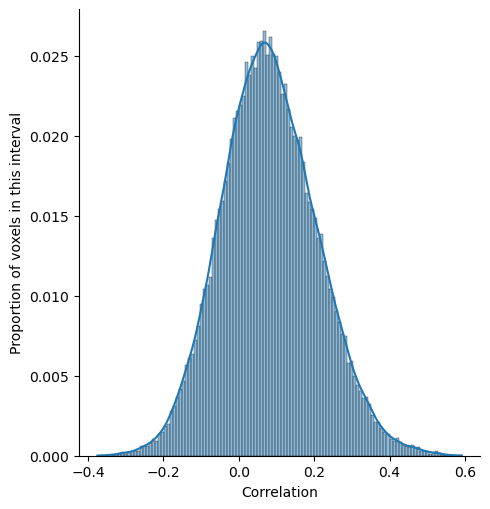

In [17]:
embds = embedding_window_size(words, ws=16, mean_last_hidden=True, device=device)
embds_lst = [v for v in embds]
transcript['embds'] = embds_lst

TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() ## Create embeddings of each TR by averaging embeddings of all words in that TR

X_mean = np.squeeze(np.array(TR_embds.values.tolist()))
wt, corrs = ridge_n_plot(X_mean, y)
print(f'{round(len([x for x in corrs_ws if x > 0.3]) / len(corrs_ws) * 100, 2)} % are bigger than 0.3')
pd.Series(corrs).describe()

### Embeddings NOT averaging last hidden vecs

100%|██████████| 3309/3309 [00:47<00:00, 68.94it/s]


4.2 % are bigger than 0.3


count    74947.000000
mean         0.054708
std          0.102475
min         -0.333455
25%         -0.015567
50%          0.050036
75%          0.119626
max          0.493647
dtype: float64

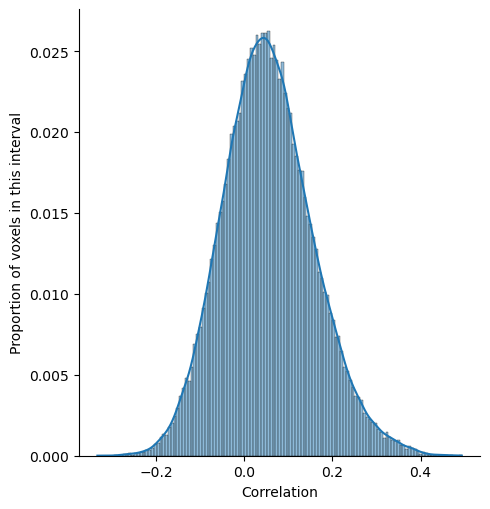

In [18]:
embds = embedding_window_size(words, ws=16, mean_last_hidden=False, device=device)
embds_lst = [v for v in embds]
transcript['embds'] = embds_lst

TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() ## Create embeddings of each TR by averaging embeddings of all words in that TR

X_not_mean = np.squeeze(np.array(TR_embds.values.tolist()))
wt, corrs = ridge_n_plot(X_not_mean, y)
print(f'{round(len([x for x in corrs_ws if x > 0.3]) / len(corrs_ws) * 100, 2)} % are bigger than 0.3')
pd.Series(corrs).describe()

## Check different window sizes - RUN WS EXAMPLE PART FIRST

### Applying regression

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import statistics
from scipy.stats import norm
import seaborn as sns

def compare_ws(wss):
    corrs_dict = {}

    for i, ws in enumerate(wss):
        m = i // 2
        n =  i % 2
        print(f'ws = {ws}')
        embds = embedding_window_size(words, ws=ws, mean_last_hidden=True, device=device)
        embds_lst = [v for v in embds]
        transcript['embds'] = embds_lst
        TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() # For each TR average the embeddings of all words that fall under this TR

        X_comapre_ws = np.squeeze(np.array(TR_embds.values.tolist()))

        wt, corrs_compare_ws = ridge_n_plot(X_comapre_ws, y, print_plot=False)
        corrs_dict[ws] = corrs_compare_ws

        corrs_total_brain = np.zeros(40962*2)
        for non_zero_idx in non_zero_activity_indices:
            corrs_total_brain[non_zero_idx] = corrs_compare_ws[non_zero_activity_dict[non_zero_idx]]
            # corrs_total_brain[non_zero_idx] = 0
        plot_stat_map(corrs_total_brain, threshold=0.25)

        
    df = pd.DataFrame(corrs_dict)
    df.index.name = "Window size"

    g = sns.displot(df, stat="probability", common_norm=False, kde=True, palette="crest")
    g.set_axis_labels("Correlation", "Proportion of voxels in this interval")
    g._legend.set_title("Window size")

compare_ws([0, 4, 8, 16, 32, 64, 128]) # 0 means embed onlt the last word heard

## Cognitive Tactic: Winodw Size and Prediction Generation - Anticipating content during listening

### 1st try

In [20]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [25]:
import logging
logging.disable(logging.WARNING)
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from tqdm import tqdm
from transformers import pipeline, set_seed
from transformers import pipeline, set_seed


def embedding_ws_pred_cont(words,ws, HF_model="gpt2", device='cpu',printi=False, mean_last_hidden=True, update_every=10):

    set_seed(42)

    print_for = 5
    tokenizer = GPT2Tokenizer.from_pretrained(HF_model, padding_side="left")
    model = GPT2Model.from_pretrained(HF_model).to(device)

    # "pranavpsv/gpt2-genre-story-generator"
    # generator = pipeline("text-generation", "pranavpsv/gpt2-genre-story-generator", device=device, pad_token_id=50256)
    
    generator = pipeline('text-generation', model='gpt2')
    vectors=[]
    for i in tqdm(range(len(words))):
        j= i-ws if i>ws else 0
        text=" ".join(words[j:i+1])
        
        if i % update_every == 0:
            l_idx = i+1 - min([30, i+1]) if i+1 > 16 else 0
            pred_cont = generator(" ".join(words[l_idx : i+1]), max_length=50)[0]['generated_text']
        text = pred_cont + '. This is the continuation of: ' + text
        inputs = tokenizer(text, return_tensors="pt").to(device)
        outputs = model(inputs.input_ids)
        if mean_last_hidden:
            last_word_embedding = np.mean(outputs.last_hidden_state.to("cpu").detach().numpy()[0], axis=0)
        else:
            last_word_embedding = outputs.last_hidden_state.to("cpu").detach().numpy()[0,-1,:]


    return vectors


pred_embds = embedding_ws_pred_cont(words,16, HF_model="gpt2", device=device, mean_last_hidden=True, update_every=1)
embds_lst = [v for v in pred_embds]
transcript['embds'] = embds_lst
TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() # For each TR average the embeddings of all words that fall under this TR

X_pred_cont = np.squeeze(np.array(TR_embds.values.tolist()))

100%|██████████| 3309/3309 [02:50<00:00, 19.36it/s]


count    74947.000000
mean         0.056540
std          0.123665
min         -0.386746
25%         -0.027440
50%          0.053385
75%          0.137967
max          0.576588
dtype: float64

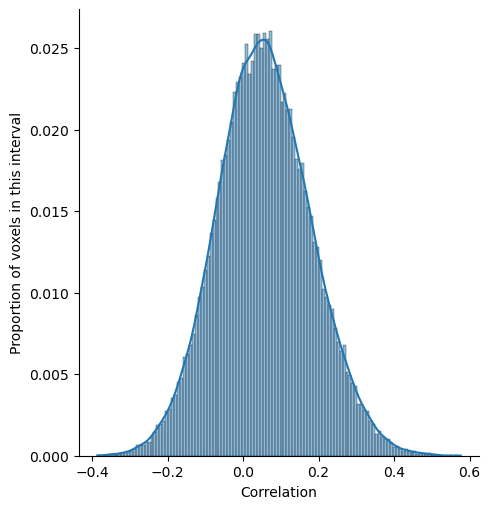

In [26]:
wt, corrs_pred = ridge_n_plot(X_pred_cont, y)
pd.Series(corrs_pred).describe()

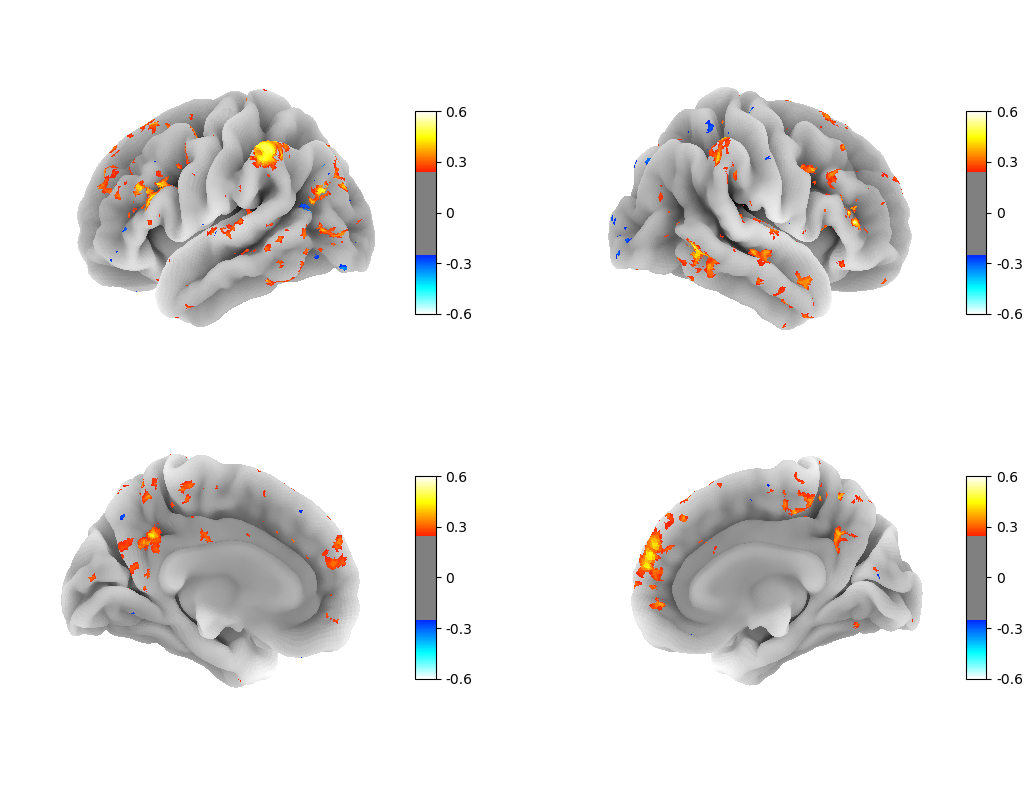

In [27]:
corrs_total_brain = np.zeros(40962*2)
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_pred[non_zero_activity_dict[non_zero_idx]]
plot_stat_map(corrs_total_brain, threshold=0.25)

### Comparing pred with baseline

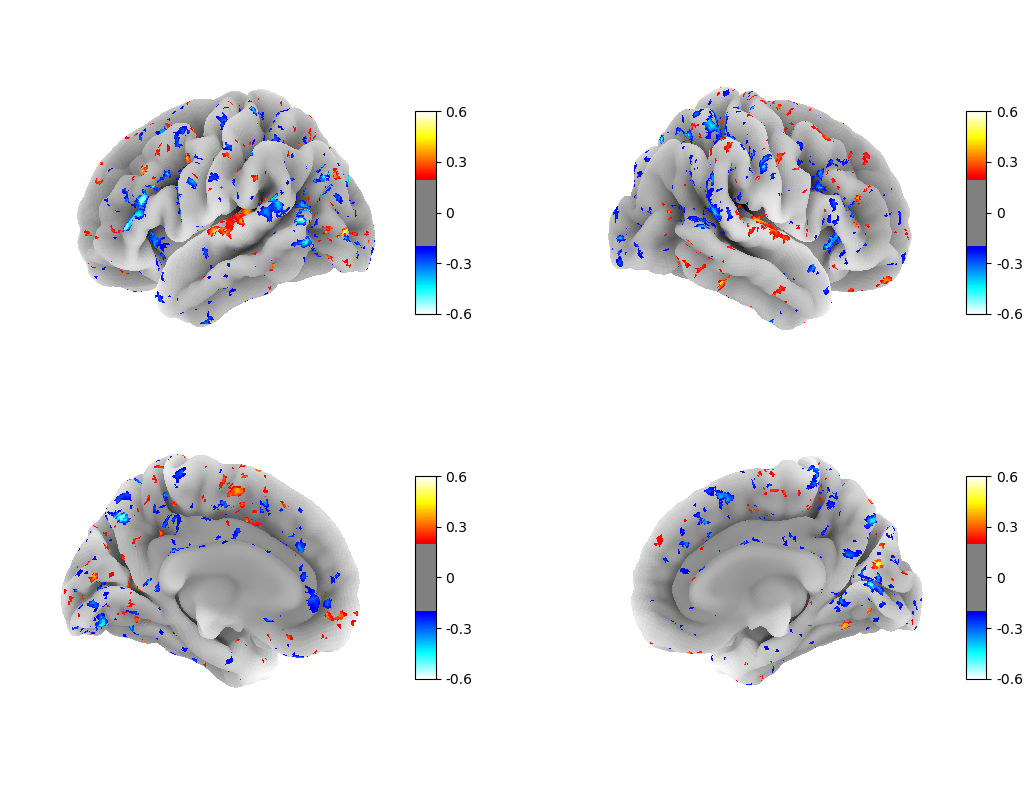

In [38]:
corrs_total_brain = np.zeros(40962*2)
corrs_diff = corrs_pred - corrs_ws
# corrs_diff = [x * (np.abs(corrs_ws[i]) > 0.2) for i, x in enumerate(corrs_diff)]
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_diff[non_zero_activity_dict[non_zero_idx]]
plot_stat_map(corrs_total_brain, threshold=0.2)

## Cognitive Tactic: Window Size With Summary

In [15]:
import logging
logging.disable(logging.WARNING)
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from tqdm import tqdm
from transformers import pipeline, set_seed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def embedding_ws_summary(words,ws, HF_model="gpt2", device='cpu',printi=False, summerize_from=20, update_every=30):

    
    tokenizer = GPT2Tokenizer.from_pretrained(HF_model)
    model = GPT2Model.from_pretrained(HF_model).to(device)

    hf_name = 'pszemraj/led-large-book-summary'
    summarizer = pipeline(
    "summarization",
    hf_name,
    device=device,
    )
    
    vectors=[]
    for i in tqdm(range(len(words))):
        # if i % 5 == 0:
        #     print(i)
        j= i-ws if i>ws else 0
        text=" ".join(words[j:i+1])
        summery = "This is a summary of the text so far: "
        if i+1 > summerize_from:
            if i % update_every == 0 or i == summerize_from:
                l_idx = max([i+1 - 500, 0]) if i+1 > 50 else 0
                text_summary = " ".join(words[l_idx:i+1])
                summery = "This is a summary of the text so far: " + summarizer(summery +" The continuation is: "+ text_summary)[0]['summary_text']

            input_t_w_summary = tokenizer(summery + ' : ' + text, return_tensors="pt").to(device)
            outputs_t_w_summary = model(input_t_w_summary.input_ids)
            summary_t_w_embedding = outputs_t_w_summary[0].to("cpu").detach().numpy()[0,-1,:]
            
            vectors.append(summary_t_w_embedding)
        else:
            inputs = tokenizer(text, return_tensors="pt").to(device)
            outputs = model(inputs.input_ids)
            last_word_embedding = outputs[0].to("cpu").detach().numpy()[0,-1,:]
            vectors.append(last_word_embedding)

    return np.array(vectors)

In [15]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
embds = embedding_ws_summary(words,16, HF_model="gpt2", device=device)
embds_lst = [v for v in embds]
transcript['embds'] = embds_lst
TR_embds = transcript[['TR_onset', 'embds']].groupby('TR_onset').mean() # For each TR average the embeddings of all words that fall under this TR

X_w_summary = np.squeeze(np.array(TR_embds.values.tolist()))

# import pickle
# with open('/home/meiri.yoav/X_w_summary.pkl', 'rb') as f:
#     X_w_summary = pickle.load(f)

In [16]:
print(X_w_summary.shape)
print(y.shape)

(844, 768)
(844, 74947)


1.68 % are bigger than 0.3


count    74947.000000
mean         0.052800
std          0.104073
min         -0.367376
25%         -0.018494
50%          0.045499
75%          0.117117
max          0.524697
dtype: float64

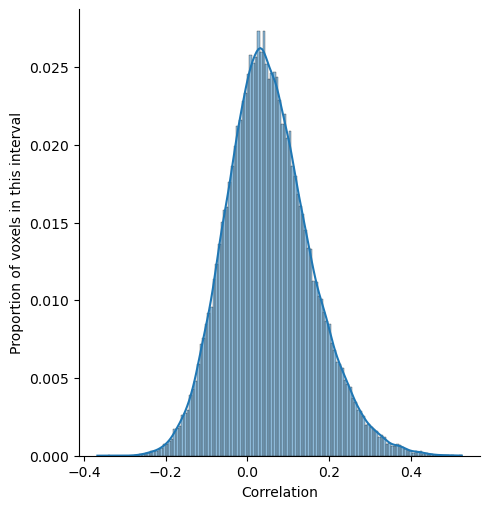

In [17]:
wt, corrs_summery = ridge_n_plot(np.vstack((X_w_summary)), y)
print(f'{round(len([x for x in corrs_summery if x > 0.3]) / len(corrs_summery) * 100, 2)} % are bigger than 0.3')
pd.Series(corrs_summery).describe()

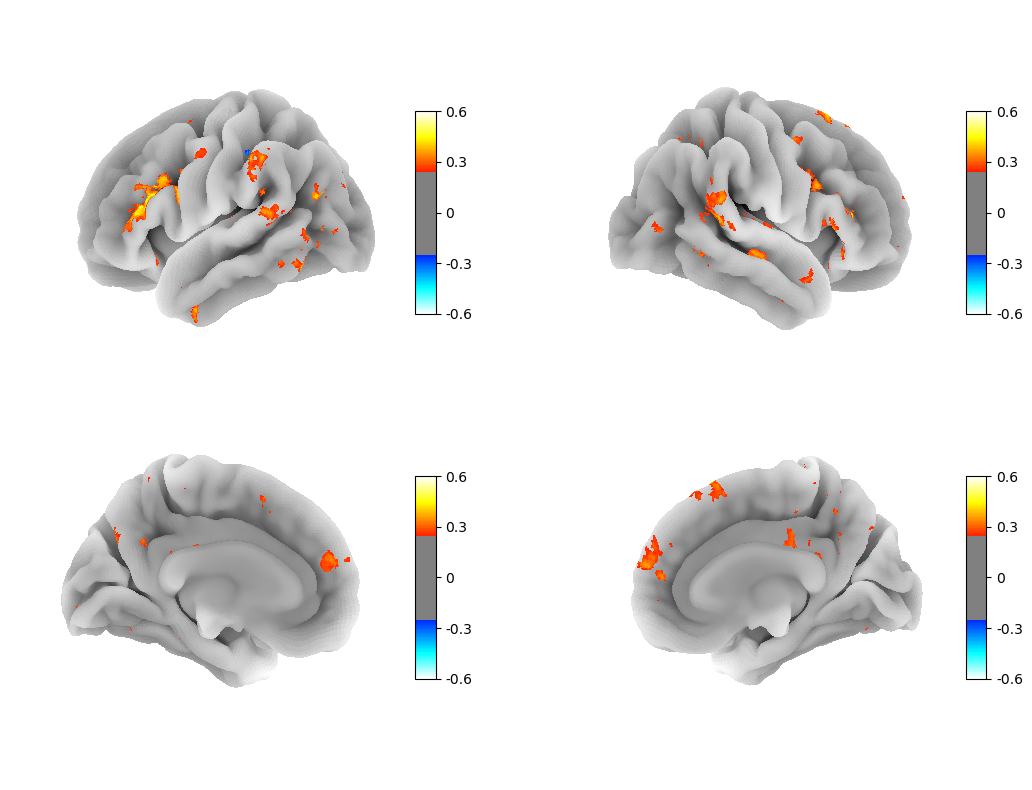

In [18]:
corrs_total_brain = np.zeros(2*40962)
for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_summery[non_zero_activity_dict[non_zero_idx]]
plot_stat_map(corrs_total_brain, threshold=0.25)

### Comparing w summery vs without summery

#### Take only voxals that passed absolute value of 0.2 and compare with summary embeddings with 0.15 threshold

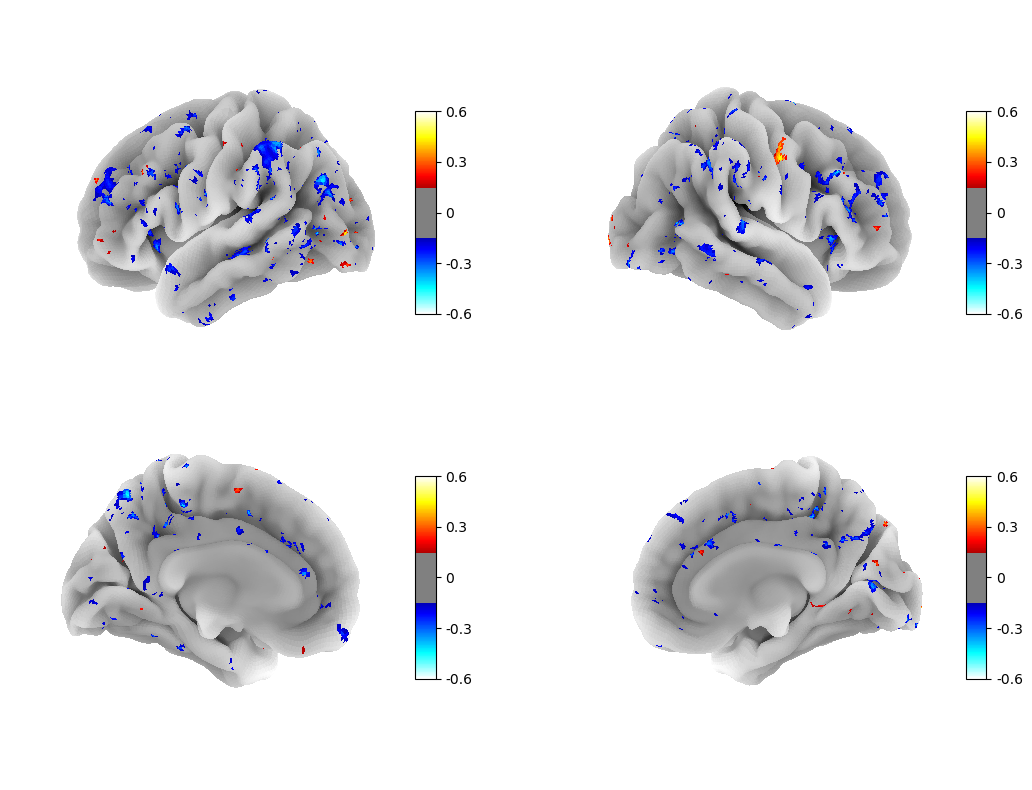

In [20]:
corrs_total_brain = np.zeros(2*40962)

corrs_diff = corrs_summery - corrs_ws
corrs_diff = [x * (np.abs(corrs_ws[i]) > 0.2) for i, x in enumerate(corrs_diff)]

for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_diff[non_zero_activity_dict[non_zero_idx]]

plot_stat_map(corrs_total_brain, threshold=0.15)

#### Compare with summary embeddings with 0.15 threshold

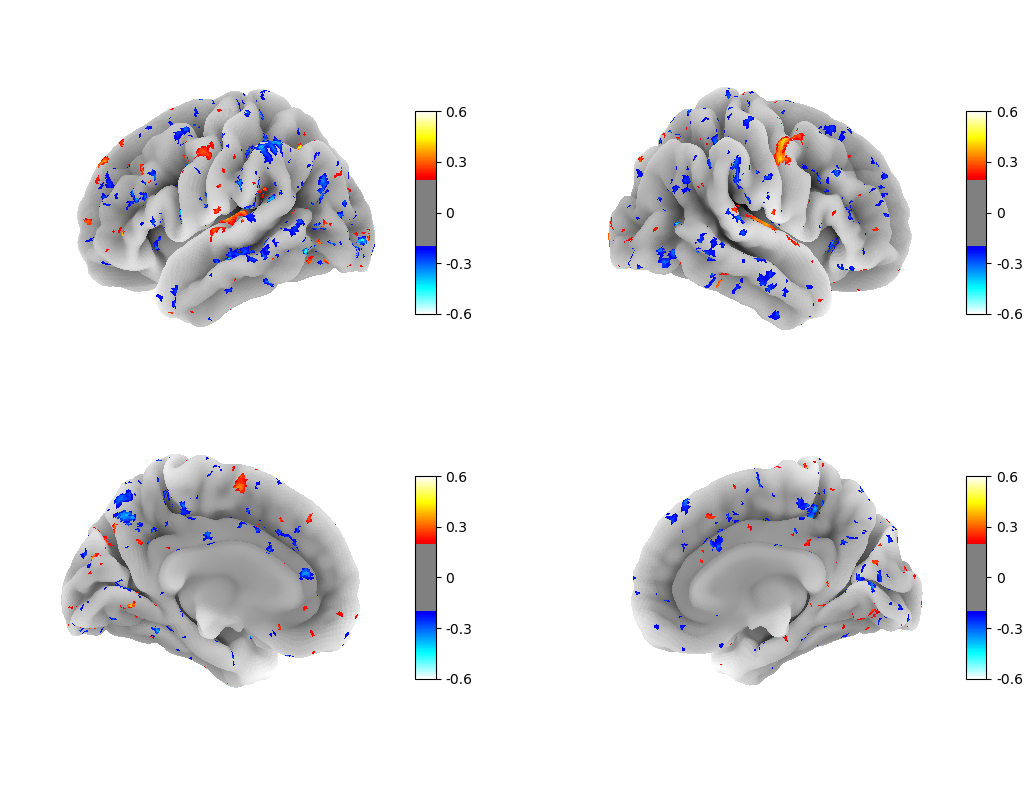

In [19]:
corrs_total_brain = np.zeros(2*40962)

corrs_diff = corrs_summery - corrs_ws
# corrs_diff = [x * (np.abs(corrs_ws[i]) > 0.2) for i, x in enumerate(corrs_diff)]

for non_zero_idx in non_zero_activity_indices:
    corrs_total_brain[non_zero_idx] = corrs_diff[non_zero_activity_dict[non_zero_idx]]

plot_stat_map(corrs_total_brain, threshold=0.2)